### Plot Prediction Result to a Heatmap

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [9]:
from common.utils.image_preprocess import read_slide

In [3]:
import os
from openslide import open_slide
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
from tqdm import tqdm

In [22]:
SOURCE_IMG_DATA_DIR = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/source_data/'
SAMPLE_PRED_DATA_DIR = '/home/sjb/Projects/Columbia/Applied_DL/CamelyonProject/data/sample_data/'

ZOOM_LEVEL = 5

In [10]:
source_slide_img_file_name = 'tumor_091.tif'
source_mask_img_file_name = 'tumor_091_mask.tif'

In [11]:
slide = open_slide(os.path.join(SOURCE_IMG_DATA_DIR, source_slide_img_file_name))
mask = open_slide(os.path.join(SOURCE_IMG_DATA_DIR, source_mask_img_file_name))

In [13]:
slide.level_dimensions

((61440, 53760),
 (30720, 26880),
 (15360, 13440),
 (7680, 6720),
 (3840, 3360),
 (1920, 1680),
 (960, 840),
 (480, 420))

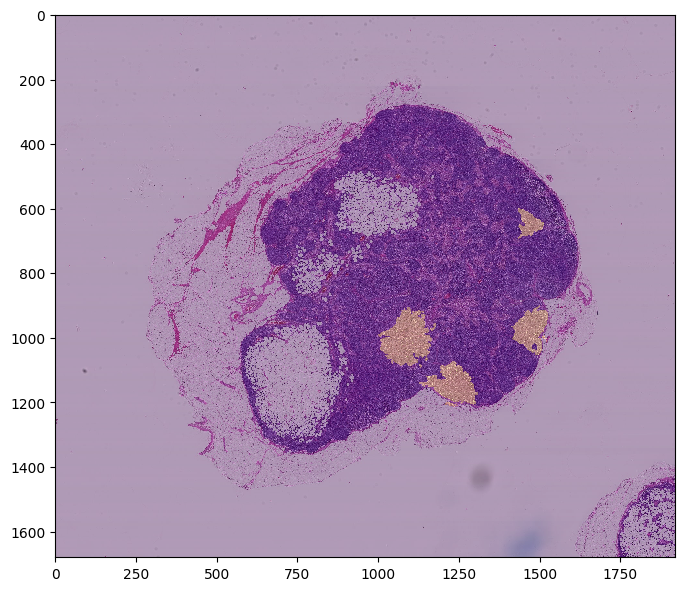

In [19]:
slide_img = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_img = read_slide(mask,
                      x=0,
                      y=0,
                      level=5,
                      width=slide.level_dimensions[5][0],
                      height=slide.level_dimensions[5][1])[:, :, 0]

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_img)
plt.imshow(mask_img, alpha=0.3)

In [21]:
mask_img.shape

(1680, 1920)

#### Post Process Prediction Mask

In [47]:
def get_row_col_id_from_file_name(file_name, component_idxes):
    components = file_name.split('.')[0].split('_')
    return (components[component_idxes[0]], components[component_idxes[1]])

def get_row_col_ids_from_file_name_list(file_name_list, component_idxes=(4, 5)):
    temp = [get_row_col_id_from_file_name(f, component_idxes=component_idxes) for f in file_name_list]
    
    row_ids, col_ids = list(zip(*temp))
    row_ids = np.sort(np.unique(row_ids).astype(int))
    col_ids = np.sort(np.unique(col_ids).astype(int))
    
    return (row_ids, col_ids)

In [63]:
def get_mask_range_for_pred(pred_row_id, pred_col_id, pred_width, pred_height, zoom_factor):
    
    x_start = int((pred_row_id * pred_height) / zoom_factor)
    x_end = int(((pred_row_id + 1) * pred_height) / zoom_factor)
    
    y_start = int((pred_col_id * pred_width) / zoom_factor)
    y_end = int(((pred_col_id + 1) * pred_width) / zoom_factor)
    
    return x_start, x_end, y_start, y_end

In [24]:
inference_file_name = 'zoom_2_200_200_slide_091_sample_pred.csv'

In [25]:
inference_df = pd.read_csv(os.path.join(SAMPLE_PRED_DATA_DIR, inference_file_name))

In [26]:
inference_df.head()

,file_name,img_id,include,label,non_gray_ratio,type,is_roi,y_pred_prob
0,tumor_slide_091_split_20_47.png,91,1,0,0.976725,test,1,0.170464
1,tumor_slide_091_split_12_19.png,91,0,0,0.000375,test,0,0.002284
2,tumor_slide_091_split_1_31.png,91,0,0,0.056050,test,0,0.002088
3,tumor_slide_091_split_22_74.png,91,0,0,0.000025,test,0,0.002124
4,tumor_slide_091_split_14_64.png,91,0,0,0.008600,test,0,0.003685


In [61]:
pred_mask = np.zeros_like(mask_img).astype(float)

In [62]:
pred_mask.sum()

0.0

In [48]:
downsample_factors = slide.level_downsamples

In [49]:
factor_ratio = downsample_factors[5] / downsample_factors[2]

In [50]:
factor_ratio

8.0

In [66]:
for idx, row in inference_df.iterrows():
    pred_row_id, pred_col_id = get_row_col_id_from_file_name(row['file_name'],
                                                             component_idxes=(4, 5))
    pred_row_id, pred_col_id = int(pred_row_id), int(pred_col_id)
    x_start, x_end, y_start, y_end = get_mask_range_for_pred(pred_row_id, 
                                                             pred_col_id, 
                                                             200, 
                                                             200, 
                                                             8)
    pred_mask[x_start:x_end, y_start:y_end] = row['y_pred_prob']

In [69]:
pred_mask.sum()

171839.57730878124

In [71]:
inference_df['y_pred_prob'].sum() * 625

171839.57730878127

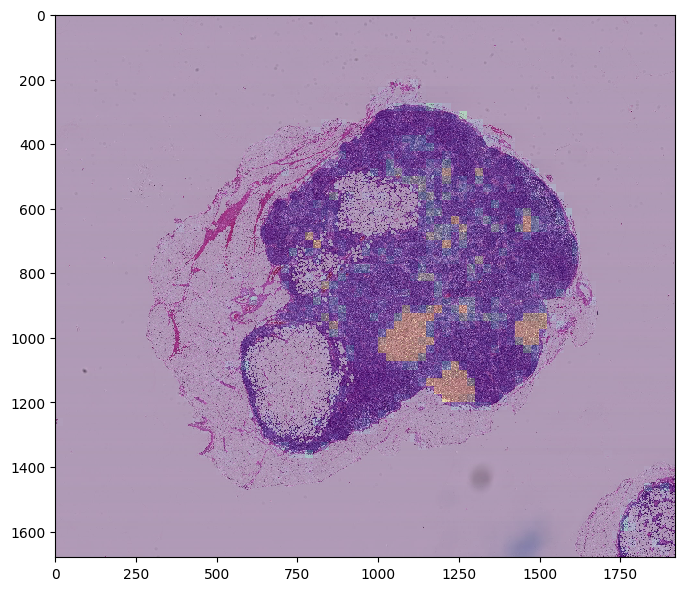

In [73]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_img)
plt.imshow(pred_mask, alpha=0.3)

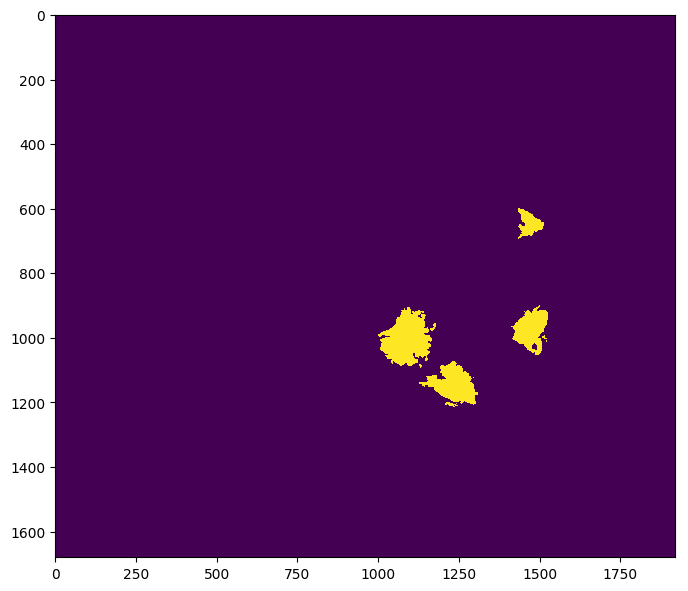

In [74]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(mask_img)

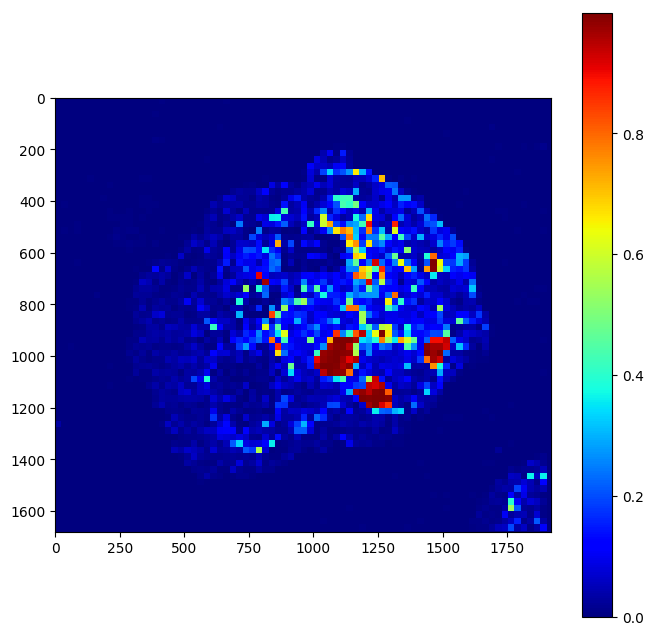

In [81]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(pred_mask, cmap='jet', interpolation='nearest')
# plt.imshow(mask_img, cmap='jet', alpha=0.1)
plt.colorbar()

In [ ]:
# plt.imshow(heat_map, cmap='jet', interpolation='nearest')
#             plt.colorbar()
#             plt.clim(0.00, 1.00)
#             plt.axis([0, heatmap_rgb.shape[1], 0, heatmap_rgb.shape[0]])
#             plt.savefig(heatmap_filename)
#             plt.clf()